In [2]:
import os
import itertools
import pickle
import math

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score
from scipy.stats import pearsonr
import krippendorff
pd.options.display.precision = 4

from lared_laughter.constants import annot_exp_path, pilot_path
from lared_laughter.utils import load_examples

In [3]:
matplotlib.rcParams.update({'font.size': 8})

# Reading the data..

In [5]:
results = load_examples(os.path.join(annot_exp_path, 'processed', 'examples_without_calibration.csv'))
cont_annot = pickle.load(open(os.path.join(annot_exp_path, 'processed', 'continuous.pkl'), 'rb'))

# Laughter stats and length

In [9]:
positives = results[results['pressed_key']]
onsets = np.concatenate(positives['onset_times'].to_list())
offsets = np.concatenate(positives['offset_times'].to_list())
laugh_lengths = offsets - onsets

<AxesSubplot:ylabel='Count'>

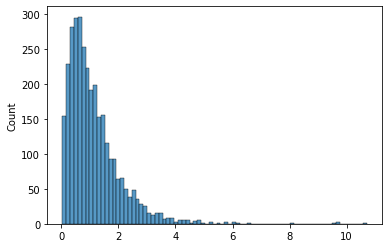

In [10]:
sns.histplot(laugh_lengths)

In [15]:
np.mean(laugh_lengths), np.percentile(laugh_lengths, 80), np.percentile(laugh_lengths, 90)

(1.1402230576683292, 1.6799999999999995, 2.2722552000000027)

# Repetition of the recognition step

Here I look at how often different annotators repeated the recognition step
- Every column is a different person.
- *repeated* is the number of times they repeated a segment once
- *total* is the number of segments they completed

In [4]:
df = []
for hit_id in results['instance_id'].unique():
    subject_data = results[results['instance_id'] == hit_id]
    df.append({'repeated': subject_data['attempt'].sum(), 'total': len(subject_data)})
pd.DataFrame(df, dtype=int).transpose()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
repeated,3,0,0,4,1,12,0,5,0,7,...,0,0,0,4,7,7,5,0,0,7
total,84,84,84,84,84,84,84,84,84,84,...,84,84,71,84,84,84,84,84,84,84


# Obvious / clear examples

In [5]:
results['duh_score'] = (results['intensity'] - results['intensity'].mean()) / results['intensity'].std() * 1/2 \
                         + (results['confidence'] - results['confidence'].mean()) / results['confidence'].std() * 1/2

In [6]:
duh_scores = []
for hash in results['hash'].unique():
    example_results = results[results['hash'] == hash]
    duh_score = example_results['duh_score'].mean()
    if len(example_results) >= 4:
        duh_score  = duh_score * 2/3 + (1-example_results['onset'].std()) * 1/3
    duh_scores.append({'hash': hash, 'score': duh_score, 'calib': example_results.iloc[0]['calibration']})

In [7]:
pd.options.display.max_colwidth

50

In [8]:
pd.options.display.max_colwidth = 100
pd.DataFrame(duh_scores).sort_values(by='score', ascending=False).head(5)

,hash,score,calib
126,8fe32db8e94826b81b1b3bcd08d829ec73a7aa7f4c6e90eba4e949d891aece52,1.1564,False
113,54265351abec7e979caf5e967c8db5f4e36d8a80e99fd9a66685842e021f767f,1.1041,False
257,9c35a317632066a07bc668ca298da67a1ae92f3117cef0f14a9480dc99ee8c68,1.0423,False
432,e8fc0665a7c28929e3a93d395027e5300d89ccffb39936af92c33d16cade2cec,0.9926,False
97,dd69f1dcdbf63a8fca17b567525a3a36b9f62a20b43c1159475b3bcd80465a2c,0.9248,False


# Duration of the experiment

Here I just read the timestamps to figure out the time that it took people to complete the experiment.

# Comparing to GT

Here I compare the results to my "GT" annotations in precision and recall. Especially interested in video-only and audio-only cases

- Every row is a HIT or annotator

In [9]:
df = {}
for instance_id in results['instance_id'].unique():
    row = {}
    for condition in results['condition'].unique():
        
        X = results.loc[(results['instance_id'] == instance_id) & (results['condition'] == condition) & (results['calibration'] == False) & results['pressed_key'].notnull()]
        # comparing laughter recognition
        precision, recall, _, _ = precision_recall_fscore_support(X['gt_laughter'].to_list(), X['pressed_key'].to_list(), labels=[0,1], zero_division=0)
        row[f'{condition}_precision'] = precision[1]
        row[f'{condition}_recall'] = recall[1]
    df[instance_id] = row
pd.DataFrame(df.values()).transpose().mean(axis=1)

audio_precision    0.9466
audio_recall       0.9306
video_precision    0.8771
video_recall       0.6930
av_precision       0.9503
av_recall          0.9348
dtype: float64

# Interannotator agreement

Pairwise interrater agreement for the categorical variables
- Laughter presence
- Laughter intensity
- Confidence

In [87]:
itertools.combinations([1,2,3,4,5], 2)

In [101]:
# check for missing modalities
for hash in results['hash'].unique():
    hash_examples = results[results['hash'] == hash]
    
    video_examples = hash_examples[hash_examples['condition'] == 'video']
    audio_examples = hash_examples[hash_examples['condition'] == 'audio']
    av_examples = hash_examples[hash_examples['condition'] == 'av']

    num_annotators = len(hash_examples['instance_id'].unique())
    if num_annotators != 6:
        print(num_annotators)

    num_examples = min(len(video_examples), len(audio_examples), len(av_examples))
    # if(num_examples != 2):
    #     print(num_examples)

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12


In [125]:
for G in results['G'].unique():
    group_examples = results[(results['G'] == G)]
    for N in results['N'].unique():
        annotator_examples = results[(results['G'] == G) & (results['N'] == N)]

        assert len(annotator_examples['instance_id'].unique()) == 2
        # print(len(annotator_examples))
        # assert len(annotator_examples) == 84, len(annotator_examples)

    assert len(group_examples['hash'].unique()) in [84, 71]

    for condition in results['condition'].unique():
        condition_examples = group_examples[group_examples['condition'] == condition]

        assert len(condition_examples['hash'].unique()) in [84, 71]

    for hash in group_examples['hash'].unique():
        hash_examples = group_examples[group_examples['hash'] == hash]
        assert len(hash_examples) == 6

        # each hash has 6 raters
        assert len(hash_examples['instance_id'].unique()) == 6

    hit_pairs = itertools.combinations(group_examples['instance_id'].unique(), 2)
    for a, b in hit_pairs:
        a = group_examples[group_examples['instance_id'] == a]
        b = group_examples[group_examples['instance_id'] == b]
        intersection = pd.merge(a, b, how='inner', on=['hash'])
        assert len(intersection) in [84, 71]

        for condition in results['condition'].unique():
            a_cond = a[a['condition'] == condition]
            b_cond = b[b['condition'] == condition]

            intersection = pd.merge(a_cond, b_cond, how='inner', on=['hash'])
            assert len(intersection) in [0, 28, 23, 24], len(intersection)
        

In [197]:
condition_map = {
    'audio': 'Audio-only',
    'video': 'Video-only',
    'av': 'Audiovisual',
}

def calc_agreement(examples, var, agreement_fn):
    values = {}
    values['condition'] = {}
    counts = {}
    for condition1 in examples['condition'].unique():
        values[condition1] = {}
        counts[condition1] = {}
        for condition2 in examples['condition'].unique():
            values[condition1][condition2] = {}
            counts[condition1][condition2] = {}
            agreement_values = []
            
            for G in examples['G'].unique():

                num_intersections = 0
                num_combinations = 0

                examples1 = examples[(examples['condition'] == condition1) & (examples['G'] == G)]
                examples2 = examples[(examples['condition'] == condition2) & (examples['G'] == G)]
                
                # get combinations of HITs in the group
                hit_pairs = itertools.permutations(examples1['instance_id'].unique(), 2)

                for hit_a, hit_b in hit_pairs:
                    a = examples1[(examples1['instance_id'] == hit_a) & examples1[var].notna()]
                    b = examples2[(examples2['instance_id'] == hit_b) & examples2[var].notna()]

                    # get the intersection of both annotator's examples
                    intersection = pd.merge(a, b, how='inner', on=['hash'])

                    # assert len(intersection) in [0, 28, 23, 24], len(intersection)

                    num_combinations += 1

                    if len(intersection) < 20:
                        if len(intersection) != 0:
                            pass
                            # print(len(intersection))
                        continue

                    num_intersections += 1

                    a = intersection[f'{var}_x'].to_numpy()
                    b = intersection[f'{var}_y'].to_numpy()
                    value = agreement_fn(a,b)


                    if value == 0:
                        print(f'zero agreement for A = {hit_a}, B={hit_b}, cond={condition}')
                    agreement_values.append(value)

            values['condition'][condition2] = condition_map[condition2]
            values[condition1][condition2] = f'{np.mean(agreement_values):.3f} ({np.std(agreement_values):.3f})'
            counts[condition1][condition2] = len(agreement_values)

    return pd.DataFrame(values), pd.DataFrame(counts)

## Kappa for binary variables

Here I calculate cohen's kappa for the three conditions for:
- pressed_key: the binarization of the continuous annotation
- is_laughter: the switch on the Rating page

In [198]:
detection_agreement = calc_agreement(results, 'pressed_key', cohen_kappa_score)[0]


zero agreement for A = 2_17bbfffed882c1619c65a4f67697a768584597d59819122fc48ea71891a38839, B=2_5ce45641a0ec2daf8b3ed29433aecd9139aa3e1ba8b0bcd344c408af3cd9bbf1, cond=av
zero agreement for A = 2_5ce45641a0ec2daf8b3ed29433aecd9139aa3e1ba8b0bcd344c408af3cd9bbf1, B=2_17bbfffed882c1619c65a4f67697a768584597d59819122fc48ea71891a38839, cond=av
zero agreement for A = 2_5ce45641a0ec2daf8b3ed29433aecd9139aa3e1ba8b0bcd344c408af3cd9bbf1, B=2_2a1cc9c5ed62ec375f44909adeecebd2546fde7b5dd9a5f205761810c627930b, cond=av
zero agreement for A = 2_2a1cc9c5ed62ec375f44909adeecebd2546fde7b5dd9a5f205761810c627930b, B=2_5ce45641a0ec2daf8b3ed29433aecd9139aa3e1ba8b0bcd344c408af3cd9bbf1, cond=av


In [199]:
print(detection_agreement.to_latex(
    header=['Condition', 'Audio-only', 'Video-only', 'Audiovisual'], index=False,
    caption='Laughter detection (Cohen\'s Kappa)',
    label='tab:detection_agreement').replace('\\begin{table}', '\\begin{subtable}{.5\\textwidth}'))

\begin{subtable}
\centering
\caption{Laughter detection (Cohen's Kappa)}
\label{tab:detection_agreement}
\begin{tabular}{llll}
\toprule
  Condition &    Audio-only &    Video-only &   Audiovisual \\
\midrule
 Audio-only & 0.823 (0.153) & 0.396 (0.186) & 0.795 (0.144) \\
 Video-only & 0.396 (0.186) & 0.550 (0.146) & 0.424 (0.183) \\
Audiovisual & 0.795 (0.144) & 0.424 (0.183) & 0.805 (0.144) \\
\bottomrule
\end{tabular}
\end{subtable}



/tmp/ipykernel_1561/3704320482.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(detection_agreement.to_latex(


## Agreement in intensity and confidence

For now I'm  calculating correelation for this. Could be that some Kappa measures or Krippendorfs alpha would be better measures

In [200]:
def pearson_corr(a, b):
    return pearsonr(a, b)[0]
def kpd_alpha(a,b):
    return krippendorff.alpha(np.vstack([a,b]), value_domain=[1,2,3,4,5,6,7], level_of_measurement='ordinal')
def norm_alpha(a,b):
    a = a - a.mean()
    b = b - b.mean()
    return krippendorff.alpha(np.vstack([a,b]), level_of_measurement='interval')

In [201]:
intensity_agreement = calc_agreement(results, 'intensity', norm_alpha)[0]

In [205]:
print(intensity_agreement.to_latex(
    header=['Condition', 'Audio-only', 'Video-only', 'Audiovisual'], index=False,
    caption='Laughter intensity (Krippendorff\'s alpha)',
    label='tab:intensity_agreement').replace('\\begin{table}', '\\begin{subtable}{.5\\textwidth}'))

\begin{subtable}{.5\textwidth}
\centering
\caption{Laughter intensity (Krippendorff's alpha)}
\label{tab:detection_agreement}
\begin{tabular}{llll}
\toprule
  Condition &    Audio-only &    Video-only &   Audiovisual \\
\midrule
 Audio-only & 0.554 (0.205) & 0.132 (0.182) & 0.532 (0.197) \\
 Video-only & 0.132 (0.182) & 0.242 (0.184) & 0.143 (0.190) \\
Audiovisual & 0.532 (0.197) & 0.143 (0.190) & 0.550 (0.176) \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_1561/498297223.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(intensity_agreement.to_latex(


In [206]:
confidence_agreement = calc_agreement(results, 'confidence', norm_alpha)[0]

In [210]:
print(confidence_agreement.to_latex(
    header=['Condition', 'Audio-only', 'Video-only', 'Audiovisual'], index=False,
    caption='Confidence in laughter rating (Krippendorff\'s alpha)',
    label='tab:confidence_agreement'
    ).replace('\\begin{table}', '\\begin{subtable}{.5\\textwidth}')
    .replace('{table}', '{subtable}'))

\begin{subtable}{.5\textwidth}
\centering
\caption{Confidence in laughter rating (Krippendorff's alpha)}
\label{tab:confidence_agreement}
\begin{tabular}{llll}
\toprule
  Condition &    Audio-only &    Video-only &   Audiovisual \\
\midrule
 Audio-only & 0.271 (0.232) & 0.076 (0.161) & 0.184 (0.240) \\
 Video-only & 0.076 (0.161) & 0.201 (0.213) & 0.085 (0.184) \\
Audiovisual & 0.184 (0.240) & 0.085 (0.184) & 0.255 (0.259) \\
\bottomrule
\end{tabular}
\end{subtable}



/tmp/ipykernel_1561/1809000079.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(confidence_agreement.to_latex(


In [ ]:
calc_agreement(results, 'confidence', pearson_corr)

,values,std,counts
audio,0.2877,0.2591,24
video,0.2011,0.2212,24
av,0.2632,0.2702,24


In [ ]:
calc_agreement(results, 'confidence', norm_alpha)

,values,std,counts
audio,0.2714,0.2320,24
video,0.2013,0.2126,24
av,0.2551,0.2587,24


# Correlating intensity and confidence

In [ ]:
len(results[
    (results['intensity'].notna() & results['confidence'].notna())
])

3877

In [ ]:
def plot_intensity_vs_confidence(condition):
    filtered = results[((results['condition'] == condition) & results['pressed_key'] & results['intensity'].notna() & results['confidence'].notna())]
    fig = sns.jointplot(x=filtered['intensity'], y=filtered['confidence'], kind='hist',
    joint_kws={'binwidth': 1, 'binrange': [0.5,7.5]},
    marginal_kws={'binwidth': 1, 'binrange': [0.5,7.5]},
    height=4,
    ratio=3,
    marginal_ticks=True)
    fig.set_axis_labels('Intensity', 'Confidence')
    fig.savefig(f'../../figures/confidence_intensity_{condition}.png', dpi=300, bbox_inches='tight')

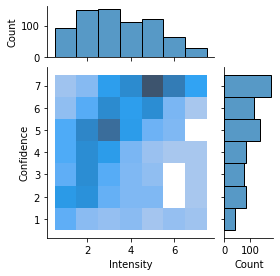

In [ ]:
plot_intensity_vs_confidence('video')

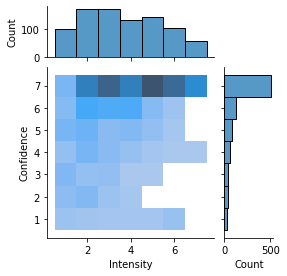

In [ ]:
plot_intensity_vs_confidence('audio')

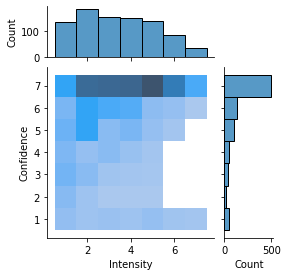

In [ ]:
plot_intensity_vs_confidence('av')

In [ ]:
from scipy.stats import spearmanr

In [ ]:
filtered = results[(results['pressed_key'] & results['intensity'].notna() & results['confidence'].notna())]
spearmanr(filtered['intensity'], filtered['confidence'])

SpearmanrResult(correlation=0.41088606039408937, pvalue=9.140339990935087e-103)

# Onset agreement

Here I plot a histogram of the differences in onset between annotations of the same segment (per condition)

- I only measure the differences when both annotators pressed the key
- Interesting plot but I think I need more samples for it to be useful

In [ ]:
results['condition'].unique()

array(['video', 'audio', 'av'], dtype=object)

In [ ]:
onset_diffs = {}
for condition in results['condition'].unique():
    onset_diffs[condition] = []

    hit_pairs = itertools.combinations(results['instance_id'].unique(), 2)
    for hit_a, hit_b in hit_pairs:
        a = results.loc[(results['instance_id'] == hit_a) & (results['condition'] == condition) & (results['calibration'] == False)]
        b = results.loc[(results['instance_id'] == hit_b) & (results['condition'] == condition) & (results['calibration'] == False)]

        # get the intersection of both annotator's examples
        intersection = pd.merge(a, b, how='inner', on=['hash'])
        if len(intersection) < 20:
            continue

        rows = intersection.loc[intersection['onset_x'].notna() & intersection['onset_y'].notna()]
        hit_diffs = np.abs(rows['onset_x'].to_numpy() - rows['onset_y'].to_numpy())
        onset_diffs[condition].append(hit_diffs)

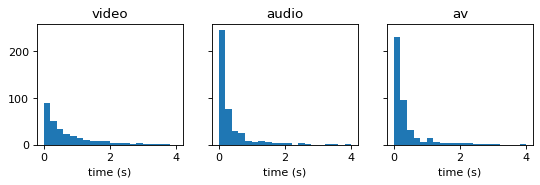

In [ ]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(8, 2), dpi=80)
for i, (condition, diffs) in enumerate(onset_diffs.items()):
    condition_diffs = np.concatenate(diffs)
    ax[i].set_title(condition)
    ax[i].set_xlabel('time (s)')
    ax[i].hist(condition_diffs, bins=np.arange(0, 4 + 0.2, 0.2))

# Annotation diagrams

Here I created diagrams of annotation onset and offset

In [ ]:
def make_annot_diagram(ax, condition, reference='gt_ini', intensity=[1,7], confidence=[1,7]):
    # ignore samples without gt laughter
    df = results.loc[
        (results['intensity'] >= intensity[0]) & 
        (results['intensity'] <= intensity[1]) & 
        (results['confidence'] >= confidence[0]) & 
        (results['confidence'] <= confidence[1]) & 
        (results['condition'] == condition) & 
        (results[reference].notna()) & 
        results['pressed_key'] &
        results['gt_laughter']]

    # print(len(df))

    cont_annots = np.full((len(df), 30*6), np.nan) # 6 seconds @ 30fps
    for i, (_, ex) in enumerate(df.iterrows()):
        ca = cont_annot[(ex['instance_id'], ex['hash'], ex['condition'])] # this is at 30fps

        center_idx = round(ex[reference] * 30)
        # print((center_idx, len(ca)))

        half1 = ca[max(0, center_idx-90): center_idx]
        cont_annots[i, 90-len(half1): 90] = half1

        half2 = ca[center_idx: center_idx+90]
        cont_annots[i, 90: 90+len(half2)] = half2
        # ex_data = ca[center_idx-90: center_idx+90]
        # if len(ex_data) != 180:
        #     # print(len(ex_data))
        #     continue

        

    times = np.arange(-3, 3, 1/30)
        
    ax.plot(times, np.nanmean(cont_annots, axis=0), linewidth=0.5)
    ax.axvline(x=0, linestyle='--', color='r', linewidth=0.5)
    ax.set_xticks(ticks=np.arange(-3,3,1))
    ax.set_xticks(ticks=np.arange(-3,3,0.2), minor=True)

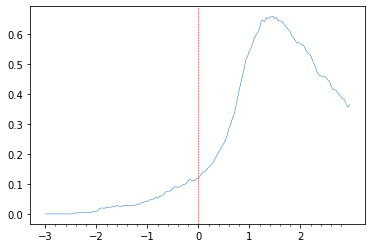

In [ ]:
fig, ax = plt.subplots()
make_annot_diagram(ax, 'video', 'gt_onset', [1,7], [1,7])

In [ ]:
def make_onset_offset_fig(intensity=[1,7], confidence=[1,7]):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(8, 4), sharey=True, sharex=True, dpi=150)
    make_annot_diagram(ax1, 'video', 'gt_onset', intensity, confidence)
    make_annot_diagram(ax2, 'audio', 'gt_onset', intensity, confidence)
    make_annot_diagram(ax3, 'av', 'gt_onset', intensity, confidence)
    make_annot_diagram(ax4, 'video', 'gt_offset', intensity, confidence)
    make_annot_diagram(ax5, 'audio', 'gt_offset', intensity, confidence)
    make_annot_diagram(ax6, 'av', 'gt_offset', intensity, confidence)
    ax1.set_title('Video')
    ax2.set_title('Audio')
    ax3.set_title('Audiovisual')
    ax5.set_xlabel('time (s)')
    ax1.set_ylabel('mean(annotations)')
    ax4.set_ylabel('mean(annotations)')
    fig.savefig('../../figures/onsets_offsets.png', dpi=300, bbox_inches='tight')

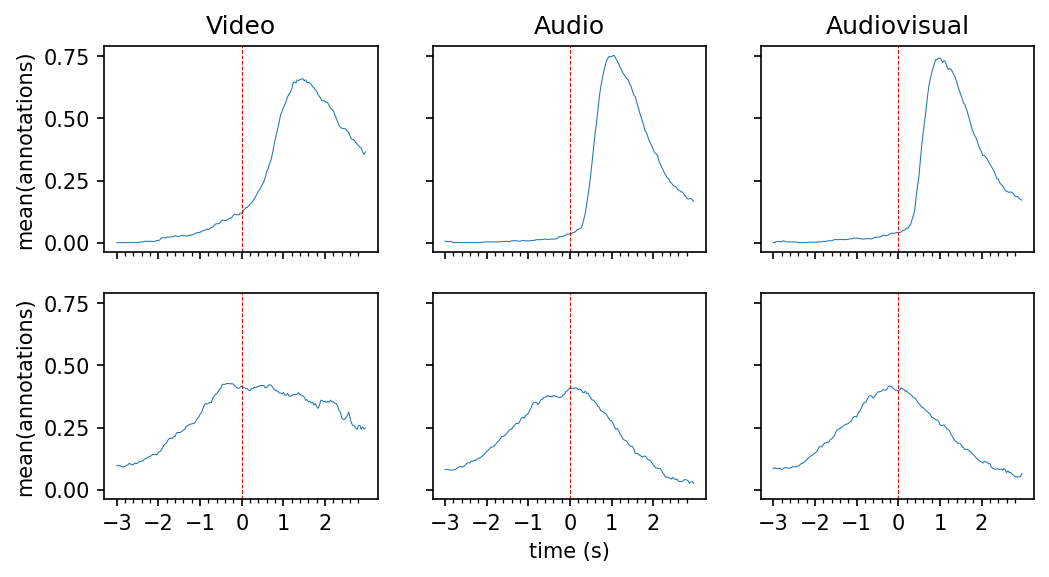

In [ ]:
make_onset_offset_fig()

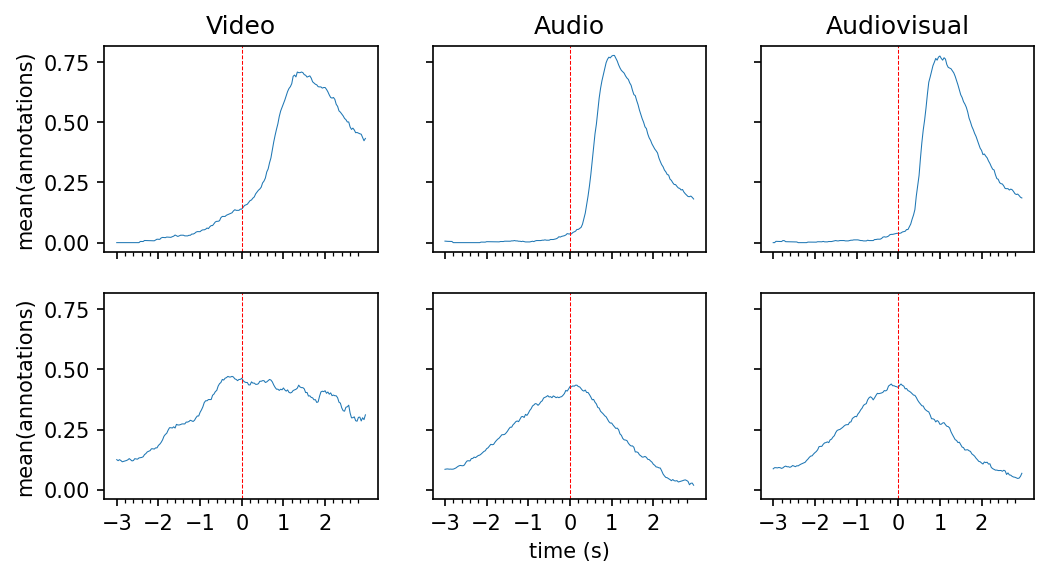

In [ ]:
make_onset_offset_fig(confidence=[5,7])

# Reaction times

In [ ]:
reaction_time_results = pickle.load(open(os.path.join(annot_exp_path, 'reaction_time_results.pkl'), 'rb'))

In [ ]:
def make_reaction_time_diagram(ax, results, intervals):
    # ignore samples without gt laughter
    video_len = len(results[0])

    video_len = np.max([len(r['data']) for r in results])

    data = []
    for res in results:
        if len(res['data']) != video_len:
            print(f'unusual length for hit_id {res["hit_id"]}')
            continue
        data.append(res['data']['data0'].to_numpy())


    data = np.vstack(data)
        
    ax.plot(np.arange(data.shape[1])*1/30, np.nanmean(data, axis=0), linewidth=0.5, color='black')
    ax.set_xlim(0,11)

    prev_end = 0.0
    for intval in intervals:
        ini = float(intval[0])
        end = float(intval[1])
        ax.axvline(x=ini, linestyle='--', color='#666666', linewidth=0.5)
        ax.axvline(x=end, linestyle='--', color='#666666', linewidth=0.5)
        ax.axvspan(prev_end, ini, facecolor='r', alpha=0.2)
        ax.axvspan(ini, end, facecolor='g', alpha=0.2)
        prev_end = end
    ax.axvspan(prev_end, 11, facecolor='0.2', alpha=0.2)

In [ ]:
def make_reaction_time_fig(reaction_time_results):

    example0_results = [ex for ex in reaction_time_results if ex['example_id'] == 0]
    example2_results = [ex for ex in reaction_time_results if ex['example_id'] == 2]
    example4_results = [ex for ex in reaction_time_results if ex['example_id'] == 4]

    fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(4, 4), sharey=True, sharex=True, dpi=300)
    make_reaction_time_diagram(ax1, example0_results, example0_results[0]['gt_intervals'])
    make_reaction_time_diagram(ax2, example2_results, example2_results[0]['gt_intervals'])
    make_reaction_time_diagram(ax3, example4_results, example4_results[0]['gt_intervals'])
    # sns.set_style("whitegrid")
    ax3.set_xlabel('Time (s)')
    ax1.set_ylabel('mean(annot)')
    ax2.set_ylabel('mean(annot)')
    ax3.set_ylabel('mean(annot)')
    ax1.yaxis.grid(True)
    ax1.xaxis.grid(False)
    ax2.yaxis.grid(True)
    ax2.xaxis.grid(False)
    ax3.yaxis.grid(True)
    ax3.xaxis.grid(False)
    ax1.set_xticks(range(0,12), minor=True)
    fig.savefig('../../figures/reaction_times.png', dpi=300, bbox_inches='tight')

unusual length for hit_id 694a4fa5b2a7733614c89f9c82605b95a39706c5f91a510d635dec64e994e19c
unusual length for hit_id ca937e8850406d600f550a0c751af3dce5cc45059621f4c530e1f8d6dbd17355
unusual length for hit_id 694a4fa5b2a7733614c89f9c82605b95a39706c5f91a510d635dec64e994e19c
unusual length for hit_id ca937e8850406d600f550a0c751af3dce5cc45059621f4c530e1f8d6dbd17355


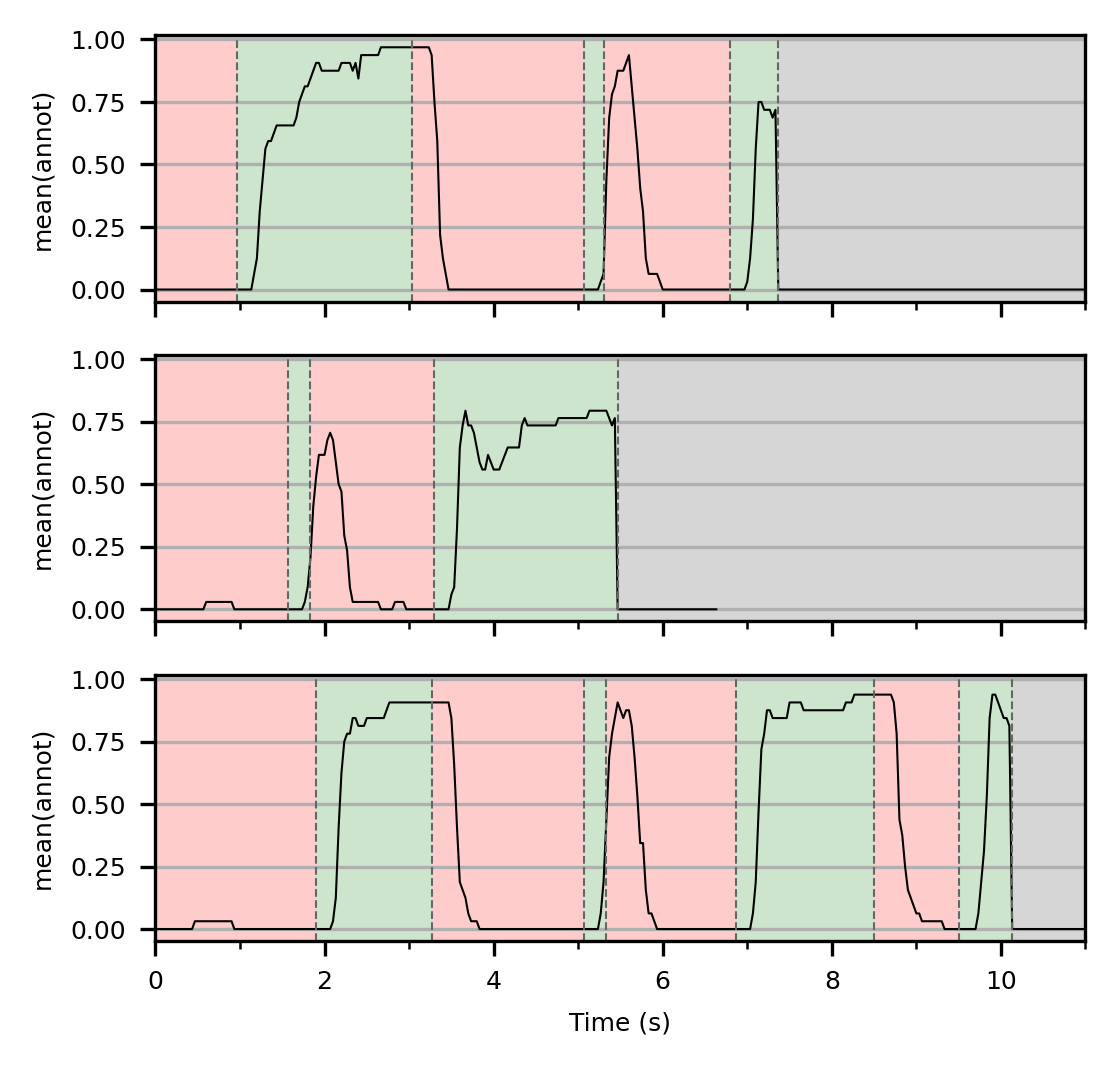

In [ ]:
matplotlib.rcParams.update({'font.size': 6})
make_reaction_time_fig(reaction_time_results)

## Delay and IoU analysis

Here I compare the onsets and overlaps with the GT directly (before correction)

In [ ]:
def intersection_over_union(a, b):
    return np.sum(np.logical_and(a, b)) / np.sum(np.logical_or(a, b))
def calc_ious(rows, correction=0.3):
    ious = []
    for i, row in rows.iterrows():
        annot = cont_annot[i]

        # create artificial signals from gt_ini and gt_end
        gt = annot.copy()
        gt['data0'] = 0
        gt.loc[(gt['media_time'] >= row['gt_ini'] + correction) & (gt['media_time'] <= row['gt_end'] + correction), 'data0'] = 1
        ious.append( intersection_over_union(annot['data0'].to_numpy(), gt['data0'].to_numpy()) )
    return ious

In [ ]:
ious = {}
corrections = np.arange(-0.5,1.5,0.1)
for condition in ['video', 'audio', 'av']:
    rows = results.loc[(results['condition'] == condition) & (results['gt_laughter'] == True) & (results['pressed_key'] == True), :]
    ious[condition] = [np.mean(calc_ious(rows, c)) for c in corrections]

Text(0, 0.5, 'Mean IoU')

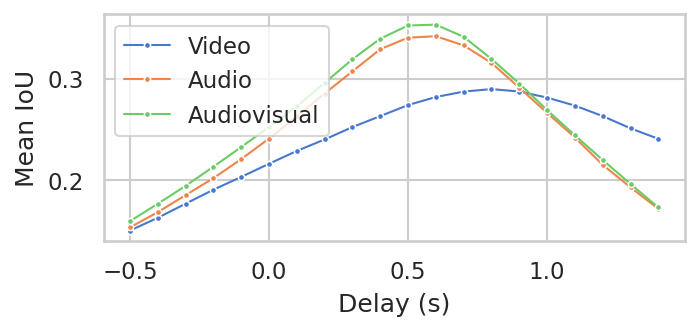

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("muted")
matplotlib.rcParams.update({'font.size': 6})
fig, ax = plt.subplots(1, 1, figsize=(5, 2), dpi=150)
x = corrections
sns.lineplot(ax=ax, x=x, y=ious['video'],label='Video', marker='o', linewidth=1, markersize=3)
sns.lineplot(ax=ax, x=x, y=ious['audio'], label= 'Audio', marker='o', linewidth=1, markersize=3)
sns.lineplot(ax=ax, x=x, y=ious['av'], label='Audiovisual', marker='o', linewidth=1, markersize=3)
ax.legend(loc='upper left')
ax.set_xlabel('Delay (s)')
ax.set_ylabel('Mean IoU')

In [ ]:
fig.savefig('./figures/ious.png', dpi=300, bbox_inches='tight')

### IoUs accross conditions

These are the average IoUs for the three different conditions, only in cases where:
- the example contained laughter (per GT)
- the example was annotated as laughter

In [ ]:
pd.DataFrame([{k: np.mean(v) for k, v in ious.items()}])

,video,audio,av
0,0.2408,0.2533,0.261


In [ ]:

ious_video = []

# Bout-level analysis

In [ ]:
def get_num_bouts(arr):
    arr = arr[arr[:,0] != 0]
    diff = np.diff(arr[:, 1])
    num_bouts = np.sum(diff == 1)
    return num_bouts

In [ ]:
num_bouts = []
for arr in cont_annot:
    num_bouts.append(get_num_bouts(arr.to_numpy()))
results['num_bouts'] = num_bouts

## How often do annotators annotate >1 bout?

Here I counted the bouts and gather some statistics on the number of bouts per annotator

- Each column is one annotator.

Clearly some people tend to consistently annotate more bouts than others, but everybody annotated 2 bouts or more at least once.

In [ ]:
df = []
for hit_id in results['hit_id'].unique():
    subject_data = results[results['hit_id'] == hit_id]
    df.append({
        '0 bouts': len(subject_data[subject_data['num_bouts'] == 0]),
        '1 bout': len(subject_data[subject_data['num_bouts'] == 1]),
        '2 bouts': len(subject_data[subject_data['num_bouts'] == 2]),
        '>2 bouts': len(subject_data[subject_data['num_bouts'] > 2]),
        'total': len(subject_data)
    })
pd.DataFrame(df).transpose()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0 bouts,28,36,36,90,23,25,27,27,32,31,...,24,27,32,26,31,90,23,29,36,33
1 bout,48,44,43,0,34,44,48,47,53,51,...,44,50,42,42,44,0,53,56,42,49
2 bouts,11,8,8,0,12,14,12,12,5,7,...,16,13,13,16,14,0,9,5,10,5
>2 bouts,3,2,3,0,4,7,3,4,0,1,...,6,0,3,6,1,0,5,0,2,3
total,90,90,90,90,73,90,90,90,90,90,...,90,90,90,90,90,90,90,90,90,90
